<a href="https://colab.research.google.com/github/walkerdustin/genAI-concept-search/blob/main/seek.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook In Google Colab"/></a>  

In [8]:
# import all packages we need
import pandas as pd
import numpy as np
import subprocess
import pickle
import pythonbible as bible
import time
import os
import matplotlib.pyplot as plt

In [2]:
# get the data
verses = pd.read_csv("https://raw.githubusercontent.com/walkerdustin/local_LLM_experiment/main/data/t_web.csv")
# prompts should be a list of strings "{citation}: {text}"
verses

,id,b,c,v,t
0,1001001,1,1,1,"In the beginning God{After ""God,"" the Hebrew h..."
1,1001002,1,1,2,Now the earth was formless and empty. Darkness...
2,1001003,1,1,3,"God said, ""Let there be light,"" and there was ..."
3,1001004,1,1,4,"God saw the light, and saw that it was good. G..."
4,1001005,1,1,5,"God called the light Day, and the darkness he ..."
...,...,...,...,...,...
31097,66022017,66,22,17,"The Spirit and the bride say, ""Come!"" He who h..."
31098,66022018,66,22,18,I testify to everyone who hears the words of t...
31099,66022019,66,22,19,If anyone takes away from the words of the boo...
31100,66022020,66,22,20,"He who testifies these things says, ""Yes, I co..."


In [3]:
# extract the bible verses from the date into a list of strings
mathew_web_ids = bible.convert_reference_to_verse_ids(bible.NormalizedReference(book=bible.Book.MATTHEW, start_chapter=1, start_verse=1, end_chapter=28, end_verse=20, end_book=None),)
references = [bible.convert_verse_ids_to_references([id])[0] for id in list(mathew_web_ids)]
vers_references = [bible.format_single_reference(reference) for reference in references]
# get all the verses coresponding to the  ids
verses = verses.loc[verses["id"].isin(mathew_web_ids), "t"].values
verses

array(['The book of the generation of Jesus Christ{Christ (Greek) and Messiah (Hebrew) both mean "Anointed One"}, the son of David, the son of Abraham.',
       'Abraham became the father of Isaac. Isaac became the father of Jacob. Jacob became the father of Judah and his brothers.',
       'Judah became the father of Perez and Zerah by Tamar. Perez became the father of Hezron. Hezron became the father of Ram.',
       ...,
       'Jesus came to them and spoke to them, saying, "All authority has been given to me in heaven and on earth.',
       'Therefore go, and make disciples of all nations, baptizing them in the name of the Father and of the Son and of the Holy Spirit,',
       'teaching them to observe all things that I commanded you. Behold, I am with you always, even to the end of the age." Amen.'],
      dtype=object)

In [4]:
len(verses)

1071

## calc how expensive this should be for different providers:
I test the following providers:
- Google Cloud
    - text bison (PaLM 2)
    - Gemini Pro
- OpenAI
    - GPT 3.5

In [5]:
sys_prompt = """You are an expert in the understanding and interpretation of the English language. You will get a single verse of the bible as an input and respond only with a single number from 0 to 10, representing
how much the given bible verse says about the concept of seeking discomfort. It is irrelevant if the verse suggests that seeking discomfort is good or bad.
For every prompt you will answer with just one number (0 to 10). 0 represents the lowest correlation to the concept of seeking comfort or 
seeking discomfort and 10 represents the highest correlation to the concept of seeking comfort or seeking discomfort.
Only answer with a single number. Do NOT give any explanation or context."""
print(f"Total Number of words in prompt: {len(sys_prompt.split())}")
total_input_words = len("".join(verses).split()) + len(sys_prompt.split())*len(verses)
print(f"Total number of words in all prompts for the whole chapter: {total_input_words:_}")
print(f"average chars per word: { len(''.join(verses))/len(''.join(verses).split()):.2f}")

Total Number of words in prompt: 119
Total number of words in all prompts for the whole chapter: 149_800
average chars per word: 5.53


## now calculate the tokens with openAIs tokenizer tiktoken
The actual cost depends on the tokens and not the words.  
One token is about 0.8 words

In [6]:
import tiktoken
tiktoken.list_encoding_names()

['gpt2', 'r50k_base', 'p50k_base', 'p50k_edit', 'cl100k_base']

In [7]:
sys_prompt

'You are an expert in the understanding and interpretation of the English language. You will get a single verse of the bible as an input and respond only with a single number from 0 to 10, representing\nhow much the given bible verse says about the concept of seeking discomfort. It is irrelevant if the verse suggests that seeking discomfort is good or bad.\nFor every prompt you will answer with just one number (0 to 10). 0 represents the lowest correlation to the concept of seeking comfort or \nseeking discomfort and 10 represents the highest correlation to the concept of seeking comfort or seeking discomfort.\nOnly answer with a single number. Do NOT give any explanation or context.'

In [8]:
"\n".join(sys_prompt)

'Y\no\nu\n \na\nr\ne\n \na\nn\n \ne\nx\np\ne\nr\nt\n \ni\nn\n \nt\nh\ne\n \nu\nn\nd\ne\nr\ns\nt\na\nn\nd\ni\nn\ng\n \na\nn\nd\n \ni\nn\nt\ne\nr\np\nr\ne\nt\na\nt\ni\no\nn\n \no\nf\n \nt\nh\ne\n \nE\nn\ng\nl\ni\ns\nh\n \nl\na\nn\ng\nu\na\ng\ne\n.\n \nY\no\nu\n \nw\ni\nl\nl\n \ng\ne\nt\n \na\n \ns\ni\nn\ng\nl\ne\n \nv\ne\nr\ns\ne\n \no\nf\n \nt\nh\ne\n \nb\ni\nb\nl\ne\n \na\ns\n \na\nn\n \ni\nn\np\nu\nt\n \na\nn\nd\n \nr\ne\ns\np\no\nn\nd\n \no\nn\nl\ny\n \nw\ni\nt\nh\n \na\n \ns\ni\nn\ng\nl\ne\n \nn\nu\nm\nb\ne\nr\n \nf\nr\no\nm\n \n0\n \nt\no\n \n1\n0\n,\n \nr\ne\np\nr\ne\ns\ne\nn\nt\ni\nn\ng\n\n\nh\no\nw\n \nm\nu\nc\nh\n \nt\nh\ne\n \ng\ni\nv\ne\nn\n \nb\ni\nb\nl\ne\n \nv\ne\nr\ns\ne\n \ns\na\ny\ns\n \na\nb\no\nu\nt\n \nt\nh\ne\n \nc\no\nn\nc\ne\np\nt\n \no\nf\n \ns\ne\ne\nk\ni\nn\ng\n \nd\ni\ns\nc\no\nm\nf\no\nr\nt\n.\n \nI\nt\n \ni\ns\n \ni\nr\nr\ne\nl\ne\nv\na\nn\nt\n \ni\nf\n \nt\nh\ne\n \nv\ne\nr\ns\ne\n \ns\nu\ng\ng\ne\ns\nt\ns\n \nt\nh\na\nt\n \ns\ne\ne\nk\ni\nn\ng\n \nd\ni\ns\

In [9]:
enc = tiktoken.get_encoding("cl100k_base") # this is the encoding for GPT 3 and 4
# https://platform.openai.com/tokenizer
# encoding and decoding should be inverses of one another
assert enc.decode(enc.encode("hello world")) == "hello world"

number_of_Tokens_in_whole_chapter = len(enc.encode("\n".join(verses)))
print(f"total tokens in whole bible chapter: {number_of_Tokens_in_whole_chapter}")

total_words = len("".join(verses).split())
total_chars = len("".join(verses))
print(f"openai tokenizer average words per token: {total_words/number_of_Tokens_in_whole_chapter}")
print(f"openai tokenizer average chars per token: {total_chars/number_of_Tokens_in_whole_chapter}")

total tokens in whole bible chapter: 29874
openai tokenizer average words per token: 0.7481756711521724
openai tokenizer average chars per token: 4.135268126129745


In [10]:
total_input_tokens = number_of_Tokens_in_whole_chapter + len(verses) * len(enc.encode(sys_prompt))
total_output_tokens = len(verses)*2 # I expect only a 2 digit number as an output
# cost for openAi GPT-3.5
cost_for_gpt35 = total_input_tokens * 1/1_000_000 + total_output_tokens * 2/1_000_000
print(f"Total cost for GPT 3.5 == {cost_for_gpt35}")
# cost for openAi GPT-4
cost_for_gpt4 = total_input_tokens * 30/1_000_000 + total_output_tokens * 60/1_000_000
print(f"Total cost for GPT 4 == {cost_for_gpt4}")
# cost for google vertex-ai gemini pro and PaLM 2
cost_for_gemini_pro = total_input_tokens * 0.25/1_000_000 + total_output_tokens * 0.5/1_000_000
print(f"Total cost for Gemini Pro == {cost_for_gemini_pro}")
# cost for mistral.ai Mistral-7B-v0.2
cost_for_mistral7B = total_input_tokens * 0.14/1_000_000 + total_output_tokens * 0.42/1_000_000
print(f"Total cost for Mistral-7B-v0.2 == {cost_for_mistral7B}")
# cost for Mistral.ai Mixtral-8X7B-v0.1, a sparse mixture of experts model with 12B active parameters.
cost_for_Mixtral8X7B = total_input_tokens * 0.6/1_000_000 + total_output_tokens * 1.8/1_000_000
print(f"Total cost for Mixtral-8X7B-v0.1 == {cost_for_Mixtral8X7B}")
# cost for mistral medium 
cost_for_MistralMedium = total_input_tokens * 2.5/1_000_000 + total_output_tokens * 7.5/1_000_000

Total cost for GPT 3.5 == 0.179814
Total cost for GPT 4 == 5.39442
Total cost for Gemini Pro == 0.0449535
Total cost for Mistral-7B-v0.2 == 0.02547384
Total cost for Mixtral-8X7B-v0.1 == 0.1091736


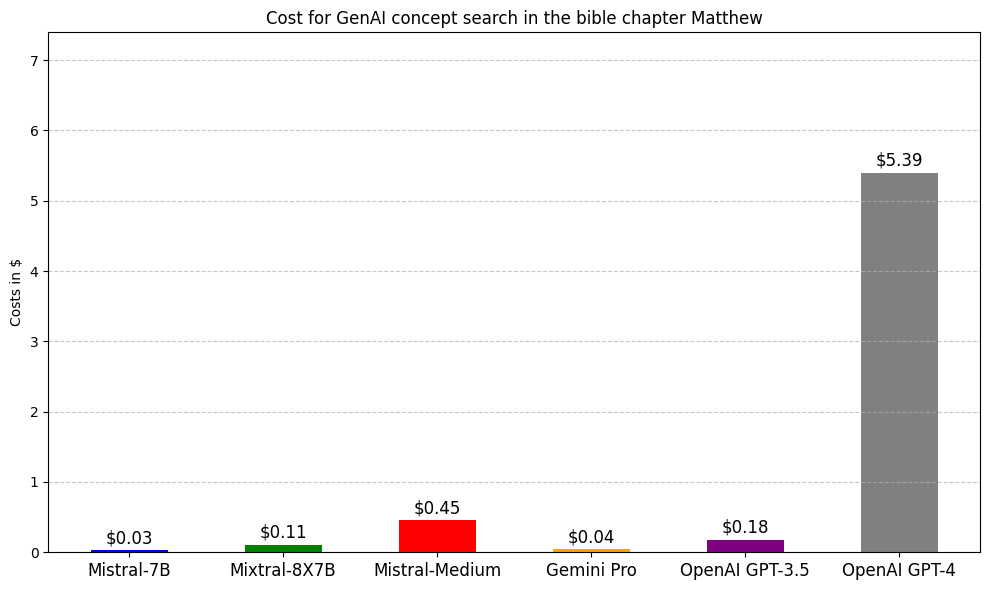

In [11]:
# import the necessary libraries
import matplotlib.pyplot as plt

# create a colorfull barplot for the costs
costs = [cost_for_mistral7B, cost_for_Mixtral8X7B, cost_for_MistralMedium ,cost_for_gemini_pro, cost_for_gpt35, cost_for_gpt4, ]
labels = ["Mistral-7B", "Mixtral-8X7B", "Mistral-Medium", "Gemini Pro", "OpenAI GPT-3.5", "OpenAI GPT-4"]
colors = ['blue', 'green', 'red', 'orange', 'purple', 'gray']

plt.figure(figsize=(10, 6))  # Adjust the figure size
plt.bar(labels, costs, color=colors, width=0.5)  # Adjust bar width and add colors
plt.ylabel("Costs in $")
plt.title("Cost for GenAI concept search in the bible chapter Matthew")

# Add data labels above the bars
for i, cost in enumerate(costs):
    plt.text(i, cost+ 0.1, f"${cost:.2f}", ha='center', fontsize=12)

plt.ylim(0, max(costs) + 2)  # Adjust the y-axis limit for better visualization

# Rotate x-axis labels for better readability
plt.xticks(ha='center', fontsize=12)

# Add a grid for better reference
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot as "costs.png" with high DPI for better quality
plt.savefig("images/costs.png", dpi=300)
plt.tight_layout()
plt.show()

## get responses from different models

In [12]:
# This is the Prompt Template I use for all Models
system_prompt = """You are an expert in the understanding and interpretation of the English language. You will get a single verse of the bible as an input and respond only with a single number from 0 to 10, representing
how much the given bible verse says about the concept of seeking discomfort. It is irrelevant if the verse suggests that seeking discomfort is good or bad.
For every prompt you will answer with just one number (0 to 10). 0 represents the lowest correlation to the concept of seeking comfort or 
seeking discomfort and 10 represents the highest correlation to the concept of seeking comfort or seeking discomfort.
Only answer with a single number. Do NOT give any explanation or context.

input: """

In [13]:
# construct a dataframe for all the verses and respones
experiment_df = pd.DataFrame({
    "vers_text": verses,
    "bible_vers_id":mathew_web_ids,
     "vers_references":vers_references
    })
experiment_df
times_df = pd.DataFrame(columns=["name", "sec"])


In [14]:
# read in the experiment df from the previous run because there the answers are already appended
# check if file is availabel
if os.path.isfile('data/experiment_df.json'):
    # read from csv
    experiment_df = pd.read_json("data/experiment_df.json")

In [15]:
experiment_df

,vers_text,bible_vers_id,vers_references
0,The book of the generation of Jesus Christ{Chr...,40001001,Matthew 1:1
1,Abraham became the father of Isaac. Isaac beca...,40001002,Matthew 1:2
2,Judah became the father of Perez and Zerah by ...,40001003,Matthew 1:3
3,Ram became the father of Amminadab. Amminadab ...,40001004,Matthew 1:4
4,Salmon became the father of Boaz by Rahab. Boa...,40001005,Matthew 1:5
...,...,...,...
1066,"But the eleven disciples went into Galilee, to...",40028016,Matthew 28:16
1067,"When they saw him, they bowed down to him, but...",40028017,Matthew 28:17
1068,"Jesus came to them and spoke to them, saying, ...",40028018,Matthew 28:18
1069,"Therefore go, and make disciples of all nation...",40028019,Matthew 28:19


### get responses from PaLM 2 (text-bison)

In [16]:
import vertexai
from vertexai.language_models import TextGenerationModel
# this authentication works in online google colab notebook
# from google.colab import auth
# auth.authenticate_user()

# !gcloud auth login  ## authentication should work in jupyter notebook

# this authentication works in a local ipython notebook and local python
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/mnt/c/Git_Repos/try-out-vertex-ai-20aaf5516b7c.json'
vertexai.init(project="try-out-vertex-ai", location="us-central1", service_account="for-local-vertex-ai@try-out-vertex-ai.iam.gserviceaccount.com")


#### Example Prompt with PaLM 2

In [17]:
parameters = {
    "candidate_count": 1,
    "max_output_tokens": 2,
    "temperature": 0,
    "top_k": 1
}
model = TextGenerationModel.from_pretrained("text-bison")
response = model.predict(system_prompt + experiment_df["vers_text"].iloc[641], **parameters)
print(f"Response from Model: {response.text}")

Response from Model:  0


In [18]:
if response.errors:
    print(f"Model had some errors: {response.errors}")

In [19]:
# 'candidates',
# 'errors',
# 'grounding_metadata',
# 'is_blocked',
# 'raw_prediction_response',
# 'safety_attributes',
# 'text'
print(response.candidates)
print(response.errors)
print(response.grounding_metadata)
print(response.is_blocked)
print(response.raw_prediction_response)
print(response.safety_attributes)

[ 0]
()
GroundingMetadata(citations=[], search_queries=[])
False
Prediction(predictions=[{'content': ' 0', 'citationMetadata': {'citations': []}, 'safetyAttributes': {'blocked': False, 'safetyRatings': [{'probabilityScore': 0.2, 'severityScore': 0.3, 'severity': 'LOW', 'category': 'Dangerous Content'}, {'probabilityScore': 0.2, 'severityScore': 0.1, 'severity': 'NEGLIGIBLE', 'category': 'Harassment'}, {'probabilityScore': 0.2, 'severityScore': 0.2, 'severity': 'NEGLIGIBLE', 'category': 'Hate Speech'}, {'probabilityScore': 0.1, 'severityScore': 0.1, 'severity': 'NEGLIGIBLE', 'category': 'Sexually Explicit'}], 'scores': [0.2, 0.3, 0.6, 0.1, 0.2, 0.1, 0.2, 0.1, 1.0, 0.1, 0.1, 0.1], 'categories': ['Derogatory', 'Finance', 'Health', 'Illicit Drugs', 'Insult', 'Legal', 'Politics', 'Public Safety', 'Religion & Belief', 'Sexual', 'Toxic', 'War & Conflict']}}], deployed_model_id='', model_version_id='', model_resource_name='', explanations=None)
{'Derogatory': 0.2, 'Finance': 0.3, 'Health': 0.6

In [20]:
# if the column text_bison_ratings already exists, then read skip this execution
if "text_bison_ratings" in list(experiment_df.columns):
    print("text_bison_ratings already exists")
else:
    # get the score for each prompt
    WAIT_TIME_AGAINST_RATE_LIMIT_IN_SECONDS = 1
    text_bison_responses = []
    text_bison_response_objects = []
    start_timestamp = time.time()
    last_start_timestamp = time.time()
    counter = 0
    for prompt in verses:
        counter += 1
        if counter%60 == 0:
            print("# the current counter is", counter)
            print("waiting")
            while time.time() - last_start_timestamp < WAIT_TIME_AGAINST_RATE_LIMIT_IN_SECONDS:
                time.sleep(0.001)
            last_start_timestamp = time.time()
        response = model.predict(system_prompt + prompt, **parameters)
        print(f"Response from Model: {response.text}")
        result = None
        if response.errors:
            result = -1
        if response.is_blocked:
            result = -2
        if not response.errors and not response.is_blocked:
            result = response.text
        text_bison_responses.append(response.text)
        text_bison_response_objects.append(response)

    total_time_for_palm2 = time.time() - start_timestamp
    print(f"all {len(verses)} prompts took: {total_time_for_palm2:.2f} seconds")

    # strip all responses
    text_bison_responses_int = [int(response.strip()) if response.strip() != "" else -3 for response in text_bison_responses ]
    
    # add text_bison_responses_int as colmn to df
    experiment_df.insert(2,"text_bison_ratings", text_bison_responses_int)
    experiment_df.insert(2,"text_bison_response_objects", text_bison_response_objects)
    
    # save time in times_df
    times_df = pd.concat([times_df, pd.DataFrame([{'name': 'text_bison', 'sec': total_time_for_palm2}])])

Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Model:  1
Response from Model:  0
Response from Model:  0
Response from Model:  0
Response from Mo

/tmp/ipykernel_21183/3734296186.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  times_df = pd.concat([times_df, pd.DataFrame([{'name': 'text_bison', 'sec': total_time_for_palm2}])])


### get responses from gemini pro

In [21]:
from vertexai.preview.generative_models import GenerativeModel
model = GenerativeModel("gemini-pro")
generation_config={
  "candidate_count": 1,
  "max_output_tokens": 2,
  "temperature": 0,
  "top_k": 1
}
prompt = "Hello Gemini!"
responses = model.generate_content(prompt, generation_config=generation_config)
print(responses.candidates[0].text)
responses

Greetings,


candidates {
  content {
    role: "model"
    parts {
      text: "Greetings,"
    }
  }
  finish_reason: MAX_TOKENS
  safety_ratings {
    category: HARM_CATEGORY_HATE_SPEECH
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_DANGEROUS_CONTENT
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_HARASSMENT
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_SEXUALLY_EXPLICIT
    probability: NEGLIGIBLE
  }
}
usage_metadata {
  prompt_token_count: 3
  candidates_token_count: 2
  total_token_count: 5
}

In [22]:
# if the column gemini_pro_ratings already exists, then read skip this execution
if "gemini_pro_ratings" in list(experiment_df.columns):
    print("gemini_pro_ratings already exists")
else:
    # get the score for each prompt
    WAIT_TIME_AGAINST_RATE_LIMIT_IN_SECONDS = 1
    gemini_pro_responses = []
    gemini_pro_response_objects = []
    start_timestamp = time.time()
    last_start_timestamp = time.time()
    counter = 0
    for prompt in verses:
        counter += 1
        if counter%60 == 0:
            print("# the current counter is", counter)
            print("waiting")
            while time.time() - last_start_timestamp < WAIT_TIME_AGAINST_RATE_LIMIT_IN_SECONDS:
                time.sleep(0.001)
            last_start_timestamp = time.time()
        try:
            response = model.generate_content(system_prompt + prompt, generation_config=generation_config)
        except Exception as e:
            text = "-3"
        else:
            try:
                text = response.candidates[0].text
            except ValueError:
                text = "-1"
        print(text)
        gemini_pro_responses.append(text)
        gemini_pro_response_objects.append(response)
    
    total_time_for_gemini_pro = time.time() - start_timestamp
    print(f"all {len(verses)} prompts took: {total_time_for_gemini_pro:.2f} seconds")

    gemini_pro_responses_int = [int(response.strip()) if response.strip() != "" else -1 for response in gemini_pro_responses ]

    experiment_df.insert(2,"gemini_pro_ratings", gemini_pro_responses_int)
    experiment_df.insert(2,"gemini_pro_response_objects", gemini_pro_response_objects)
    
    # save time in times_df
    times_df = pd.concat([times_df, pd.DataFrame([{'name': 'gemini_pro', 'sec': total_time_for_gemini_pro}])])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
# the current counter is 60
waiting
0
0
0
0
0
0
8
2
2
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
7
0
0
0
8
10
0
3
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
-1
7
# the current counter is 120
waiting
8
0
0
0
0
0
0
0
0
2
5
5
0
-1
7
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
5
# the current counter is 180
waiting
7
0
0
0
0
7
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
# the current counter is 240
waiting
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
7
0
0
0
0
0
0
-1
0
0
0
0
5
2
0
0
0
# the current counter is 300
waiting
0
0
0
0
0
0
0
7
0
0
0
7
8
0
0
0
0
0
0
0
0
0
0
0
0
0
0
7
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
# the current counter is 360
waiting
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

In [23]:
pd.set_option('display.max_colwidth', 0)
experiment_df.sort_values("gemini_pro_ratings", ascending=False)[["vers_text", "gemini_pro_ratings", "text_bison_ratings"]].head(20)

,vers_text,gemini_pro_ratings,text_bison_ratings
100,"""Blessed are you when people reproach you, persecute you, and say all kinds of evil against you falsely, for my sake.",10,8
590,"If your hand or your foot causes you to stumble, cut it off, and cast it from you. It is better for you to enter into life maimed or crippled, rather than having two hands or two feet to be cast into the eternal fire.",8,7
591,"If your eye causes you to stumble, pluck it out, and cast it from you. It is better for you to enter into life with one eye, rather than having two eyes to be cast into the Gehenna{or, Hell} of fire.",8,5
65,Then Jesus was led up by the Spirit into the wilderness to be tempted by the devil.,8,8
311,He who finds his life will lose it; and he who loses his life for my sake will find it.,8,5
99,"Blessed are those who have been persecuted for righteousness' sake, For theirs is the Kingdom of Heaven.",8,5
551,"Then Jesus said to his disciples, ""If anyone desires to come after me, let him deny himself, and take up his cross, and follow me.",8,8
119,"If your right hand causes you to stumble, cut it off, and throw it away from you: for it is profitable for you that one of your members should perish, and not your whole body be thrown into Gehenna.",8,5
179,For everyone who asks receives. He who seeks finds. To him who knocks it will be opened.,7,7
310,"He who doesn't take his cross and follow after me, isn't worthy of me.",7,5


## use Openai Api

In [24]:
# set the openai Api key in the enviroment with
# setx OPENAI_API_KEY "your-api-key-here"

# or in python with
# os.environ["OPENAI_API_KEY"] = "your-api-key-here"

In [25]:
system_prompt = """You are an expert in the understanding and interpretation of the English language. You will get a single verse of the bible as an input and respond only with a single number from 0 to 10, representing
how much the given bible verse says about the concept of seeking discomfort. It is irrelevant if the verse suggests that seeking discomfort is good or bad.
For every prompt you will answer with just one number (0 to 10). 0 represents the lowest correlation to the concept of seeking comfort or 
seeking discomfort and 10 represents the highest correlation to the concept of seeking comfort or seeking discomfort.
Only answer with a single number. Do NOT give any explanation or context.
"""

In [26]:
from openai import OpenAI
client = OpenAI()
# defaults to getting the key using os.environ.get("OPENAI_API_KEY")
# if you saved the key under a different environment variable name, you can do something like:
# client = OpenAI(
#   api_key=os.environ.get("CUSTOM_ENV_NAME"),
# )
def get_GPT3_5_response(prompt):
  completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    max_tokens=2,
    temperature=0,
    messages=[
      {"role": "system", "content": system_prompt},
      {"role": "user", "content": prompt}
    ]
  )
  return completion
print(get_GPT3_5_response(verses[30]).choices[0].message)

ChatCompletionMessage(content='2', role='assistant', function_call=None, tool_calls=None)


In [27]:
completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": verses[310]}
  ]
)
print(completion.choices[0].message.content)
completion

8


ChatCompletion(id='chatcmpl-8v3IwbIA8m4hv5ob2YBRVv36DDrxk', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='8', role='assistant', function_call=None, tool_calls=None))], created=1708608090, model='gpt-3.5-turbo-0125', object='chat.completion', system_fingerprint='fp_cbdb91ce3f', usage=CompletionUsage(completion_tokens=1, prompt_tokens=165, total_tokens=166))

In [28]:
def convert_to_int(s):
    try:
        return int(s)
    except ValueError:
        return -1

In [29]:
# if the column gpt_3_5_ratings already exists, then read skip this execution
if "gpt_3_5_ratings" in list(experiment_df.columns):
    print("gpt3_5_ratings already exists")
else:
    # get the score for each prompt
    gpt_3_5_responses = []
    gpt_3_5_response_objects = []
    start_timestamp = time.time()
    last_start_timestamp = time.time()
    counter = 0
    for prompt in verses:
        counter += 1
        if counter%60 == 0:
            print("# the current counter is", counter)
        response = get_GPT3_5_response(prompt)
        print(response.choices[0].message.content)
        gpt_3_5_responses.append(response.choices[0].message.content)
        gpt_3_5_response_objects.append(response)
    
    total_time_for_gpt3_5 = time.time() - start_timestamp
    print("all", len(verses), "prompts took:", total_time_for_gpt3_5, "seconds")
    
    gpt_3_5_responses_int = [convert_to_int(response.strip()) if response.strip() != "" else -3 for response in gpt_3_5_responses ]

    experiment_df.insert(2,"gpt_3_5_ratings", gpt_3_5_responses_int)
    experiment_df.insert(2,"gpt_3_5_response_objects", gpt_3_5_response_objects)
    
    # save time in times_df
    times_df = pd.concat([times_df, pd.DataFrame([{'name': 'gpt_3_5', 'sec': total_time_for_gpt3_5}])])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
2
1
0
0
2
0
2
2
2
2
0
2
2
2
2
2
2
2
8
8
1
2
0
2
0
2
1
2
1
2
2
2
8
1
1
8
2
2
2
2
# the current counter is 60
2
2
2
2
2
1
10
8
2
2
8
8
2
2
2
2
2
2
2
0
2
2
2
2
2
8
2
8
2
5
1
2
0
2
2
2
7
2
2
2
8
8
2
2
2
2
2
2
2
2
2
0
2
2
2
2
2
0
1
8
# the current counter is 120
8
0
1
2
1
0
1
2
0
8
8
7
2
1
2
2
8
2
2
2
2
2
2
2
2
2
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
7
2
2
2
2
2
2
2
2
2
2
2
7
7
2
2
8
# the current counter is 180
8
2
2
2
2
8
8
2
7
2
2
8
1
2
2
0
2
2
2
8
1
2
1
2
2
2
1
1
1
2
2
2
2
2
2
1
2
2
0
2
2
8
2
8
1
8
2
2
2
2
2
1
2
8
2
7
1
2
1
2
# the current counter is 240
5
8
1
1
2
2
2
2
2
2
2
2
2
2
2
2
7
2
2
2
2
1
2
2
2
2
1
1
2
1
2
2
2
2
2
0
0
0
2
1
2
2
8
8
2
1
2
7
2
8
8
2
2
2
2
8
8
2
2
2
# the current counter is 300
2
2
2
1
2
2
2
8
7
2
8
8
8
2
2
2
1
2
2
2
2
2
2
2
2
1
2
8
2
2
2
2
3
2
3
2
2
1
2
1
2
1
0
2
2
2
2
1
2
8
2
1
2
1
1
2
2
1
2
2
# the current counter is 360
2
0
0
1
1
2
1
2
1
1
2
2
2
1
8
2
0
2
2
2
2
2
2
2
2
2
2
2
8
2
2
2
1
1
1
2
2
1
2
2
7
2
8
2
2
1
2
2
2
2
2
2
8
2


In [48]:
from openai import OpenAI

client = OpenAI()
def get_GPT4_response(prompt):
  completion = client.chat.completions.create(
    model="gpt-4",
    max_tokens=2,
    temperature=0,
    messages=[
      {"role": "system", "content": system_prompt},
      {"role": "user", "content": prompt}
    ]
  )
  return completion
print(get_GPT4_response(verses[30]).choices[0].message)

ChatCompletionMessage(content='0', role='assistant', function_call=None, tool_calls=None)


In [49]:
# if the column gpt_4_ratings already exists, then read skip this execution
if "gpt_4_ratings" in list(experiment_df.columns):
    print("gpt_4_ratings already exists")
else:
    # get the score for each prompt
    gpt_4_responses = []
    gpt_4_response_objects = []
    start_timestamp = time.time()
    last_start_timestamp = time.time()
    counter = 0
    for prompt in verses:
        counter += 1
        if counter%60 == 0:
            print("# the current counter is", counter)
        response = get_GPT4_response(prompt)
        print(response.choices[0].message.content)
        gpt_4_responses.append(response.choices[0].message.content)
        gpt_4_response_objects.append(response)
    
    total_time_for_gpt_4 = time.time() - start_timestamp
    print("all", len(verses), "prompts took:", total_time_for_gpt_4, "seconds")
    
    gpt_4_responses_int = [convert_to_int(response.strip()) if response.strip() != "" else -3 for response in gpt_4_responses ]

    experiment_df.insert(2,"gpt_4_ratings", gpt_4_responses_int)
    experiment_df.insert(2,"gpt_4_response_objects", gpt_4_response_objects)
    
    # save time in times_df
    times_df = pd.concat([times_df, pd.DataFrame([{'name': 'gpt_4', 'sec': total_time_for_gpt_4}])])

0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
1
1
0
0
0
5
0
1
1
1
0
0
0
0
1
1
0
1
1
4
2
0
1
0
8
0
2
1
2
0
2
4
2
7
1
2
1
4
0
1
2
# the current counter is 60
1
4
7
1
1
0
8
8
1
2
1
7
1
1
7
1
1
1
1
0
0
2
4
0
5
7
1
7
1
1
1
1
0
7
7
1
7
0
0
0
8
9
7
1
1
1
1
0
0
1
6
0
0
1
2
2
1
0
1
9
# the current counter is 120
9
0
1
0
0
0
0
1
1
9
8
8
1
1
8
1
4
2
5
2
2
2
2
2
1
1
1
0
1
1
0
4
0
1
7
7
2
7
1
2
0
2
2
7
1
2
1
1
1
1
1
2
2
0
1
2
2
7
1
1
# the current counter is 180
7
1
1
1
1
8
8
1
1
0
0
1
0
2
1
1
1
2
7
2
0
1
1
1
1
1
0
2
0
1
1
0
0
8
0
1
1
1
6
2
7
8
1
7
1
2
2
2
0
2
7
0
1
1
0
1
0
1
0
1
# the current counter is 240
1
1
0
0
7
1
7
2
2
7
7
1
1
1
1
7
7
1
0
1
1
0
1
1
2
1
1
1
1
0
2
1
7
6
2
0
0
0
4
7
2
2
8
8
1
0
1
7
1
7
8
8
4
0
2
8
2
1
7
1
# the current counter is 300
2
2
0
0
0
1
1
8
8
5
7
9
8
0
1
1
1
2
1
0
1
1
7
7
2
1
1
7
0
0
1
1
1
7
4
1
2
1
1
1
1
0
0
7
2
2
2
1
3
1
1
0
1
0
0
1
1
0
1
2
# the current counter is 360
1
0
0
1
1
1
0
1
0
0
1
1
1
1
2
1
0
0
1
1
0
1
1
1
1
7
1
1
7
1
2
0
0
1
0
1
0
0
1
1
3
2
2
0
1
1
1
2
2
1
2
1
2
1
1

In [51]:
experiment_df.columns

Index(['vers_text', 'bible_vers_id', 'gpt_4_response_objects', 'gpt_4_ratings',
       'mistral_medium_response_objects', 'mistral_medium_ratings',
       'mistral_small_response_objects', 'mistral_small_ratings',
       'mistral_tiny_response_objects', 'mistral_tiny_ratings',
       'ollama_llama13B_response_objects', 'ollama_llama13B_ratings',
       'ollama_llama7B_response_objects', 'ollama_llama7B_ratings',
       'ollama_mistral7B_response_objects', 'ollama_mistral7B_ratings',
       'gpt_3_5_response_objects', 'gpt_3_5_ratings',
       'gemini_pro_response_objects', 'gemini_pro_ratings',
       'text_bison_response_objects', 'text_bison_ratings', 'vers_references'],
      dtype='object')

In [57]:
experiment_df.sort_values("mistral_medium_ratings", ascending=False)[["vers_text", "gemini_pro_ratings", "text_bison_ratings", "gpt_3_5_ratings", "gpt_4_ratings", "ollama_mistral7B_ratings", "mistral_medium_ratings"]].head(20)

,vers_text,gemini_pro_ratings,text_bison_ratings,gpt_3_5_ratings,gpt_4_ratings,ollama_mistral7B_ratings,mistral_medium_ratings
551,"Then Jesus said to his disciples, ""If anyone desires to come after me, let him deny himself, and take up his cross, and follow me.",8,8,8,9,10,9
133,"But I tell you, love your enemies, bless those who curse you, do good to those who hate you, and pray for those who mistreat you and persecute you,",7,5,2,8,10,8
548,"From that time, Jesus began to show his disciples that he must go to Jerusalem and suffer many things from the elders, chief priests, and scribes, and be killed, and the third day be raised up.",7,2,8,9,10,8
119,"If your right hand causes you to stumble, cut it off, and throw it away from you: for it is profitable for you that one of your members should perish, and not your whole body be thrown into Gehenna.",8,5,8,9,0,8
220,"Jesus said to him, ""The foxes have holes, and the birds of the sky have nests, but the Son of Man has nowhere to lay his head.""",2,0,8,8,10,8
666,"and will hand him over to the Gentiles to mock, to scourge, and to crucify; and the third day he will be raised up.""",5,0,2,8,0,8
310,"He who doesn't take his cross and follow after me, isn't worthy of me.",7,5,8,9,5,8
311,He who finds his life will lose it; and he who loses his life for my sake will find it.,8,5,8,8,5,8
130,"Whoever compels you to go one mile, go with him two.",5,5,7,8,0,8
552,"For whoever desires to save his life will lose it, and whoever will lose his life for my sake will find it.",7,0,8,8,5,8


In [31]:
# # safe the experiment_df as csv
# experiment_df.to_csv("experiment_df.csv")

## Use local Ollama with mistral7B
Ollama is a cli that runs large language model inferenc on your local machine.  
It is currently the most popular tool to run open source LLMs locally.  
Ollama does not yet run on windows natively, so I use WSL to run it on my machine.  
my specs: 
- GTX 1070 (8GB GDDR5-VRAM) (overclocked to 1911 MHz)
- i5 6600K (overclocked to 4.5 GHz)

```bash
ollama create seeker_mistral -f mistral7B_llm
```

```bash
ollama run seeker_mistral "Enter through the narrow gate. For wide is the gate and broad is the road that leads to destruction, and many enter through it."
```


In [32]:
import ollama

In [33]:
# if the column ollama_mistral7B_ratings already exists, then read skip this execution
if "ollama_mistral7B_ratings" in list(experiment_df.columns):
    print("ollama_mistral7B_ratings already exists")
else:
    # read modelfile into string
    model_file = open('./ollama_modelfile/mistral7B_llm').read()
    model_name = "seeker_mistral"
    ollama.create(model=model_name, modelfile=model_file)
    
    # get the score for each prompt
    ollama_mistral7B_responses = []
    ollama_mistral7B_response_objects = []
    start_timestamp = time.time()
    last_start_timestamp = time.time()
    counter = 0
    for prompt in verses:
        counter += 1
        if counter%60 == 0:
            print("# the current counter is", counter)
        response_object = ollama.generate(model=model_name, prompt=prompt)
        response = response_object["response"]
        print(response)
        ollama_mistral7B_responses.append(response)
        ollama_mistral7B_response_objects.append(response_object)
    
    total_time_for_ollama_mistral7B = time.time() - start_timestamp
    print(f"all {len(verses)} prompts took: {total_time_for_ollama_mistral7B:.2f} seconds")
    
    ollama_mistral7B_responses_int = [convert_to_int(response.strip().split(".")[0]) if response.strip() != "" else -3 for response in ollama_mistral7B_responses ]

    experiment_df.insert(2,"ollama_mistral7B_ratings", ollama_mistral7B_responses_int)
    experiment_df.insert(2,"ollama_mistral7B_response_objects", ollama_mistral7B_response_objects)
    
    # save time in times_df
    times_df = pd.concat([times_df, pd.DataFrame([{'name': 'ollama_mistral7B', 'sec': total_time_for_ollama_mistral7B}])])

 0. This verse
 0.
 0. This verse
 0.


 0. This verse
 0. This verse
 0. This verse
 0. This verse
 0. This verse
 0. This verse
 0. This verse
 0. This verse
 0. This verse
 0. This verse
 0.
 0. This verse
 0. This verse
 0. This verse
 0. This verse
 0. This verse
 0. This verse
 0.
 0. This verse
 0. This verse
 0. This verse
 2.
 0. This verse
 5.
 0. This verse
 0.
 0. This verse
 0. This verse
 5.


 0. This verse
 0.
 0. This verse
 0. This verse
 10. This
 0.
 0. This verse
 10. This
 0. This verse
 10.
 0.
 0. This verse
 0. This verse
 5.
 0. This verse
 5.
 0. This verse
 5.


 8.


 0. This verse
 0. This verse
 8.


 0. This verse
 0. This verse
 8.


 0. This verse
# the current counter is 60
 0. This verse
 0. This verse
 0. This verse
 0. This verse
 0. This verse
 0. This verse
 10.

 10.
 0. This verse
 3. This verse
 0.
 0. This verse
 0. This verse
 3.


 5. This verse
 0. This verse
 0. This verse
 0.
 0.
 0. This verse
 0.
 0. This verse
 0. This verse
 0. This 

## run with llama2:7b

In [34]:
import ollama
# read modelfile into string
model_file = open('./ollama_modelfile/llama2_7B').read()
model_name = "seeker_llama7B"
ollama.create(model=model_name, modelfile=model_file)

# if the column ollama_llama7B_ratings already exists, then read skip this execution
if "ollama_llama7B_ratings" in list(experiment_df.columns):
    print("ollama_llama7B_ratings already exists")
else:
    # get the score for each prompt
    ollama_llama7B_responses = []
    ollama_llama7B_response_objects = []
    start_timestamp = time.time()
    last_start_timestamp = time.time()
    counter = 0
    for prompt in verses:
        counter += 1
        if counter%60 == 0:
            print("# the current counter is", counter)
        response_object = ollama.generate(model=model_name, prompt=prompt)
        response = response_object["response"]
        print(response)
        ollama_llama7B_responses.append(response)
        ollama_llama7B_response_objects.append(response_object)

    total_time_for_ollama_llama7B = time.time() - start_timestamp
    print(f"all {len(verses)} prompts took: {total_time_for_ollama_llama7B:.2f} seconds")
    
    ollama_llama7B_responses_int = [convert_to_int(response.strip().split(".")[0]) if response.strip() != "" else -3 for response in ollama_llama7B_responses ]

    experiment_df.insert(2,"ollama_llama7B_ratings", ollama_llama7B_responses_int)
    experiment_df.insert(2,"ollama_llama7B_response_objects", ollama_llama7B_response_objects)
    
    # save time in times_df
    times_df = pd.concat([times_df, pd.DataFrame([{'name': 'ollama_llama7B', 'sec': total_time_for_ollama_llama7B}])])


7

7

6

6

7

7

7

7

6

6

6

6

6

6

6

8

8

7

7

8

8

8

7

7

8

7

7

7

7

8

7

6

8

7

8

8

6

7

7

7

8

7

8

7

7

7

6

7

7

8

8

7

7

8

7

8

7

7

8
# the current counter is 60

7

7

6

8

8

8

7

6

7

8

6

8

7

7

7

8

7

7

7

8

6

7

7

7

7

8

6

7

8

8

7

7

7

8

7

7

8

7

7

7

8

7

7

7

7

7

8

7

7

7

8

6

7

7

7

7

8

7

7

8
# the current counter is 120

7

7

7

7

7

7

6

8

5

7

7

7

7

5

8

7

7

7

8

5

6

8

8

7

7

7

7

7

8

8

7

8

7

7

7

7

8

5

8

7

7

7

7

8

7

7

8

7

8

7

8

8

8

7

7

7

7

8

7

8
# the current counter is 180

8

7

7

8

7

7

8

7

7

7

7

7

7

7

7

8

7

8

7

7

7

7

7

7

8

7

8

8

7

8

7

8

8

8

8

6

7

8

8

7

7

7

7

8

7

6

7

8

8

7

6

7

7

7

7

7

6

7

7

7
# the current counter is 240

7

8

6

8

7

7

7

7

8

6

7

7

8

7

7

8

6

8

7

6

7

7

7

7

7

7

7

7

8

7

8

8

7

7

8

8

7

6

6

8

8

8

7

7

7

7

7

7

7

7

7

8

8

8

5

7


In [35]:
# read modelfile into string
model_file = open('./ollama_modelfile/llama2_13B').read()
model_name = "seeker_llama13B"
ollama.create(model=model_name, modelfile=model_file)

# if the column ollama_llama13B_ratings already exists, then read skip this execution
if "ollama_llama13B_ratings" in list(experiment_df.columns):
    print("ollama_llama13B_ratings already exists")
else:
    # get the score for each prompt
    ollama_llama13B_responses = []
    ollama_llama13B_response_objects = []
    start_timestamp = time.time()
    last_start_timestamp = time.time()
    counter = 0
    for prompt in verses:
        counter += 1
        if counter%60 == 0:
            print("# the current counter is", counter)
        response_object = ollama.generate(model=model_name, prompt=prompt)
        response = response_object["response"]
        print(response)
        ollama_llama13B_responses.append(response)
        ollama_llama13B_response_objects.append(response_object)

    total_time_for_ollama_llama13B = time.time() - start_timestamp
    print(f"all {len(verses)} prompts took: {total_time_for_ollama_llama7B:.2f} seconds")
    
    ollama_llama13B_responses_int = [convert_to_int(response.strip().split(".")[0]) if response.strip() != "" else -3 for response in ollama_llama13B_responses ]

    experiment_df.insert(2,"ollama_llama13B_ratings", ollama_llama13B_responses_int)
    experiment_df.insert(2,"ollama_llama13B_response_objects", ollama_llama13B_response_objects)
    
    # save time in times_df
    times_df = pd.concat([times_df, pd.DataFrame([{'name': 'ollama_llama13B', 'sec': total_time_for_ollama_llama13B}])])


I would rate this

5

Okay, here



I would rate this

Okay, here

I would rate this

I would rate this

I would rate this

I would rate this

I would rate this

I would rate the

I would rate this

I would rate this

I would rate this

I would rate this

5

I would rate this

I would rate this

5

Based on the

5

I would rate this

Okay, here

Okay, I

5

5

Okay, here

5

5

I would rate this

Okay, here

5

Okay, here

Okay, here

5

5

6

Based on the

5

Okay, here

5

I understand, and

Okay, here

I would rate this

Okay, here

5

Based on the

Okay, here

8

5

Based on the

5

5

5

Based on the

5

Okay, here

Okay, I

I would rate this
# the current counter is 60

8

5

Okay, I

5

8

8

5

5

Okay, I

Okay, I

5

Okay, I

Okay, I

8

Okay, here

Based on the

6

Okay, here

5

7

Okay, I

5

Okay, here

Okay, here

Okay, here

6

5

5

5

6

5

5

5

5

5

5

5

5

5

5

6

8

5

Okay, here

6

5

5

Okay, here

Based on the

5

5

Okay, I

Based on the

Okay, I

5

5

5

Okay, I

5

5
# the current counter

## run with mistral.ai api

### Chat Completions API
| Model |	    Input               |	Output       |
|---------------|-------------------|-----------------|
|mistral-tiny	|0.14€ / 1M tokens	|0.42€ / 1M tokens|
|mistral-small	|0.6€ / 1M tokens	|1.8€ / 1M tokens|
|mistral-medium	|2.5€ / 1M tokens	|7.5€ / 1M tokens|

In [36]:
# set the openai Api key in the enviroment with
# setx MISTRAL_API_KEY "your-api-key-here"

# or in python with
# os.environ["MISTRAL_API_KEY"] = "your-api-key-here"

In [37]:
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage

api_key = os.environ["MISTRAL_API_KEY"]
model = "mistral-tiny"

client = MistralClient(api_key=api_key)

# No streaming
def get_mistral_response(model, prompt):
    chat_response_object = client.chat(
        model=model,
        messages=[ChatMessage(role="system", content=sys_prompt), ChatMessage(role="user", content=prompt)],
        temperature=0,
        max_tokens=2
    )
    return chat_response_object
get_mistral_response(model, verses[10]).choices[0].message.content

'0'

In [38]:
# if the column mistral_tiny_ratings already exists, then read skip this execution
if "mistral_tiny_ratings" in list(experiment_df.columns):
    print("mistral_tiny_ratings already exists")
else:
    model = "mistral-tiny"
    # get the score for each prompt
    mistral_tiny_responses = []
    mistral_tiny_response_objects = []
    start_timestamp = time.time()
    last_start_timestamp = time.time()
    counter = 0
    for prompt in verses:
        counter += 1
        if counter%60 == 0:
            print("# the current counter is", counter)
        response = get_mistral_response(model, prompt)
        print(response.choices[0].message.content)
        mistral_tiny_responses.append(response.choices[0].message.content)
        mistral_tiny_response_objects.append(response)
    
    total_time_for_mistral_tiny = time.time() - start_timestamp
    print("all", len(verses), "prompts took:", total_time_for_mistral_tiny, "seconds")
    
    mistral_tiny_responses_int = [convert_to_int(response.strip()) if response.strip() != "" else -3 for response in mistral_tiny_responses ]

    experiment_df.insert(2,"mistral_tiny_ratings", mistral_tiny_responses_int)
    experiment_df.insert(2,"mistral_tiny_response_objects", mistral_tiny_response_objects)
    
    # save time in times_df
    times_df = pd.concat([times_df, pd.DataFrame([{'name': 'mistral_tiny', 'sec': total_time_for_mistral_tiny}])])

0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
0
5
0
0
0
0
5
0
0
0
0
1
5
0
1
2
1
0
0
0
5
0
8
0
5
1
0
0
8
0
0
8
0
# the current counter is 60
0
0
0
0
0
0
1
1
3
5
8
2
0
8
8
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
8
0
0
0
8
1
0
0
0
0
0
0
0
0
0
0
0
5
5
0
0
0
5
1
# the current counter is 120
8
0
0
0
0
0
0
0
0
5
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
8
2
5
0
0
0
0
8
8
0
0
0
0
0
0
0
0
5
0
0
0
0
8
0
1
5
# the current counter is 180
5
0
0
0
0
1
8
0
8
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
5
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
8
0
0
8
8
0
8
8
0
0
0
0
0
0
# the current counter is 240
5
0
0
0
0
0
5
5
2
0
5
0
0
0
0
5
2
0
5
0
0
0
0
0
0
0
0
0
0
0
0
8
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
0
5
8
5
0
0
1
1
0
0
5
0
# the current counter is 300
0
0
0
0
0
0
0
1
1
0
0
8
5
0
0
0
0
0
0
0
0
0
5
2
5
2
0
8
0
0
0
0
8
8
3
0
0
0
0
0
0
0
0
1
0
0
5
0
5
0
0
0
0
0
0
0
8
0
0
1
# the current counter is 360
0
0
0
0
0
0
0
0
0
0
0
0
0
0
8
0
0
0
0
0
0
0
0
0
8
0
0
0
8
2
8
0
0
0
0
0
0
0
0
0
0
1
8
0
0
0
0
0
0
0
0
0
8
0
0
5
8
1
0

In [40]:
# if the column mistral_small_ratings already exists, then read skip this execution
if "mistral_small_ratings" in list(experiment_df.columns):
    print("mistral_small_ratings already exists")
else:
    model = "mistral-small"
    # get the score for each prompt
    mistral_small_responses = []
    mistral_small_response_objects = []
    start_timestamp = time.time()
    last_start_timestamp = time.time()
    counter = 0
    for prompt in verses:
        counter += 1
        if counter%60 == 0:
            print("# the current counter is", counter)
        response = get_mistral_response(model, prompt)
        print(response.choices[0].message.content)
        mistral_small_responses.append(response.choices[0].message.content)
        mistral_small_response_objects.append(response)
    
    total_time_for_mistral_small = time.time() - start_timestamp
    print("all", len(verses), "prompts took:", total_time_for_mistral_small, "seconds")
    
    mistral_small_responses_int = [convert_to_int(response.strip()) if response.strip() != "" else -3 for response in mistral_small_responses ]

    experiment_df.insert(2,"mistral_small_ratings", mistral_small_responses_int)
    experiment_df.insert(2,"mistral_small_response_objects", mistral_small_response_objects)
    
    # save time in times_df
    times_df = pd.concat([times_df, pd.DataFrame([{'name': 'mistral_small', 'sec': total_time_for_mistral_small}])])

I would
1
0
0
1
1
0
0
0
0
1
0
0
0
0
0
I would
0
1
0
0
"Be
0
1
0
1
0
0
1
1
1
1
2
1
0
0
2
8
8
1
0
1
2
0
2
1
8
I would
2
1
2
9
1
1
1
1
1
1
1
# the current counter is 60
1
1
1
1
1
0
9
8
0
2
1
2
2
0
0
1
0
2
1
1
1
1
1
1
1
2
1
2
1
0
1
1
0
1
2
1
1
1
1
1
8
9
8
1
1
1
1
0
1
1
1
1
0
1
2
0
1
0
0
2
# the current counter is 120
1
1
1
1
1
1
I would
1
1
9
8
8
1
1
2
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
0
1
1
2
1
2
1
1
1
1
1
1
2
1
2
2
1
1
2
1
2
0
0
1
1
2
1
1
2
# the current counter is 180
8
1
1
1
1
1
8
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
1
1
0
0
1
9
0
8
1
2
1
1
1
0
2
0
0
1
1
0
1
1
1
1
# the current counter is 240
1
1
0
1
1
1
1
2
1
1
7
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
0
8
1
2
1
1
1
0
1
1
1
1
1
8
1
1
1
2
0
9
9
2
1
1
0
8
2
1
1
1
# the current counter is 300
1
1
1
1
1
1
1
9
8
0
2
9
9
1
1
1
1
1
1
1
0
1
1
8
1
2
1
2
1
0
0
1
2
2
1
1
1
0
1
0
1
1
1
0
0
1
2
0
I would
1
1
1
1
1
1
1
1
1
1
0
# the current counter is 360
1
1
1
1
1
1
0
1
1
0
1
0
1
1
1
1
0
0
1
1
I would
1
1
0
2
1
1
1
8
2
0
0
0
2
1
1

In [41]:
# if the column mistral_medium_ratings already exists, then read skip this execution
if "mistral_medium_ratings" in list(experiment_df.columns):
    print("mistral_medium_ratings already exists")
else:
    model = "mistral-medium"
    # get the score for each prompt
    mistral_medium_responses = []
    mistral_medium_response_objects = []
    start_timestamp = time.time()
    last_start_timestamp = time.time()
    counter = 0
    for prompt in verses:
        counter += 1
        if counter%60 == 0:
            print("# the current counter is", counter)
        response = get_mistral_response(model, prompt)
        print(response.choices[0].message.content)
        mistral_medium_responses.append(response.choices[0].message.content)
        mistral_medium_response_objects.append(response)
    
    total_time_for_mistral_medium = time.time() - start_timestamp
    print("all", len(verses), "prompts took:", total_time_for_mistral_medium, "seconds")
    
    mistral_medium_responses_int = [convert_to_int(response.strip()) if response.strip() != "" else -3 for response in mistral_medium_responses ]

    experiment_df.insert(2,"mistral_medium_ratings", mistral_medium_responses_int)
    experiment_df.insert(2,"mistral_medium_response_objects", mistral_medium_response_objects)
    
    # save time in times_df
    times_df = pd.concat([times_df, pd.DataFrame([{'name': 'mistral_medium', 'sec': total_time_for_mistral_medium}])])

0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
1
1
1
1
1
0
1
1
0
1
0
2
0
0
1
0
1
1
1
1
1
7
1
1
1
0
7
0
1
0
3
1
1
1
1
7
0
1
3
2
1
2
2
# the current counter is 60
3
1
1
1
1
0
7
8
1
1
1
7
2
2
3
1
1
1
1
0
0
1
2
1
1
1
1
1
1
2
0
1
0
1
3
1
3
1
1
1
8
8
5
3
1
2
1
1
1
1
3
1
1
1
2
3
3
0
1
8
# the current counter is 120
8
1
1
1
3
0
1
3
1
7
3
8
2
1
8
3
1
2
2
1
2
1
2
1
2
1
1
0
1
1
1
1
1
1
7
1
2
2
2
1
1
2
3
3
1
1
1
0
2
3
1
2
1
1
3
3
2
3
2
5
# the current counter is 180
5
1
1
1
1
7
2
1
2
1
1
2
1
2
1
1
1
1
2
1
1
1
1
1
1
1
0
1
1
1
1
1
1
7
1
0
1
1
1
1
1
8
1
5
1
5
1
3
1
3
3
0
1
3
1
3
0
1
1
1
# the current counter is 240
2
3
0
1
1
1
3
3
3
5
3
2
5
1
0
1
2
1
3
1
0
0
1
1
1
1
1
1
1
1
1
2
3
3
3
0
0
1
1
1
1
2
3
5
1
1
1
2
2
5
8
3
2
1
1
8
5
1
2
3
# the current counter is 300
3
5
1
1
1
1
1
3
7
1
3
8
8
1
1
1
1
0
0
1
1
2
3
3
1
1
2
3
0
1
1
1
3
3
2
3
1
1
1
3
3
1
1
1
1
1
2
1
1
3
3
1
2
1
0
1
2
1
1
0
# the current counter is 360
1
1
0
1
1
1
1
1
0
1
2
1
1
2
5
2
1
1
1
1
1
1
1
1
1
8
3
1
3
1
3
1
1
1
0
1
0
1
1
3
3
5
5
1
1
1
1
1
1
2
2
1
1
1
1

In [60]:
experiment_df.to_csv("data/experiment_df.csv")

In [59]:
experiment_df.to_json("data/experiment_df.json")

In [63]:
times_df.to_csv("data/times_df.csv")

In [74]:
times_df

,name,sec
0,text_bison,549.711793
1,gemini_pro,456.114870
2,gpt_3_5,2752.802603
3,gpt_4,1070.960249
4,ollama_mistral7B,1201.558121
5,ollama_llama7B,1091.680313
6,ollama_llama13B,3446.577645
7,mistral_tiny,3814.597317
8,mistral_small,908.788969
9,mistral_medium,666.963465


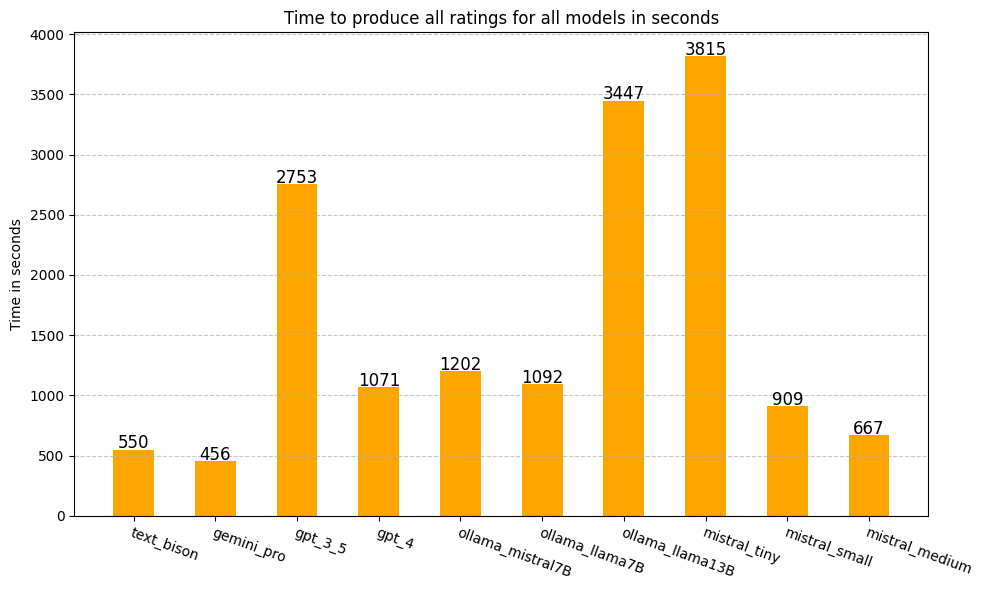

In [88]:
# compare how long each model took to process all the prompts
# make a bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size
plt.bar(times_df.name, times_df.sec, color='orange', width=0.5)  # Adjust bar width and add colors
plt.ylabel("Time in seconds")
plt.title("Time to produce all ratings for all models in seconds")

# Add data labels above the bars
for i, el in enumerate(np.round(times_df.sec)):
    plt.text(i, el + 10, f"{el:.0f}", ha='center', fontsize=12)

plt.ylim(0, max(times_df.sec) + 200)  # Adjust the y-axis limit for better visualization

# Rotate x-axis labels for better readability
plt.xticks(ha='left', fontsize=10, rotation=-20, wrap=True)

# Add a grid for better reference
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot as "costs.png" with high DPI for better quality
plt.savefig("images/times.png", dpi=300)
plt.tight_layout()
plt.show()

### Analyze reliability
The rating is set to less than 0 if something failed.  
Lets count all the cells where the rating is less than 0 and visualize the numbers in a barplot.

In [5]:
ratings_columns = [col for col in experiment_df.columns if "ratings" in col]
ratings_columns

['gpt_4_ratings',
 'mistral_medium_ratings',
 'mistral_small_ratings',
 'mistral_tiny_ratings',
 'ollama_llama13B_ratings',
 'ollama_llama7B_ratings',
 'ollama_mistral7B_ratings',
 'gpt_3_5_ratings',
 'gemini_pro_ratings',
 'text_bison_ratings']

In [6]:
# count the cells with ratings less than 0
counts = {}
for col in ratings_columns:
    counts[col] = experiment_df[col].map(lambda el: 1 if el < 0 else 0).sum()
counts

{'gpt_4_ratings': 0,
 'mistral_medium_ratings': 0,
 'mistral_small_ratings': 20,
 'mistral_tiny_ratings': 2,
 'ollama_llama13B_ratings': 495,
 'ollama_llama7B_ratings': 0,
 'ollama_mistral7B_ratings': 3,
 'gpt_3_5_ratings': 0,
 'gemini_pro_ratings': 31,
 'text_bison_ratings': 0}

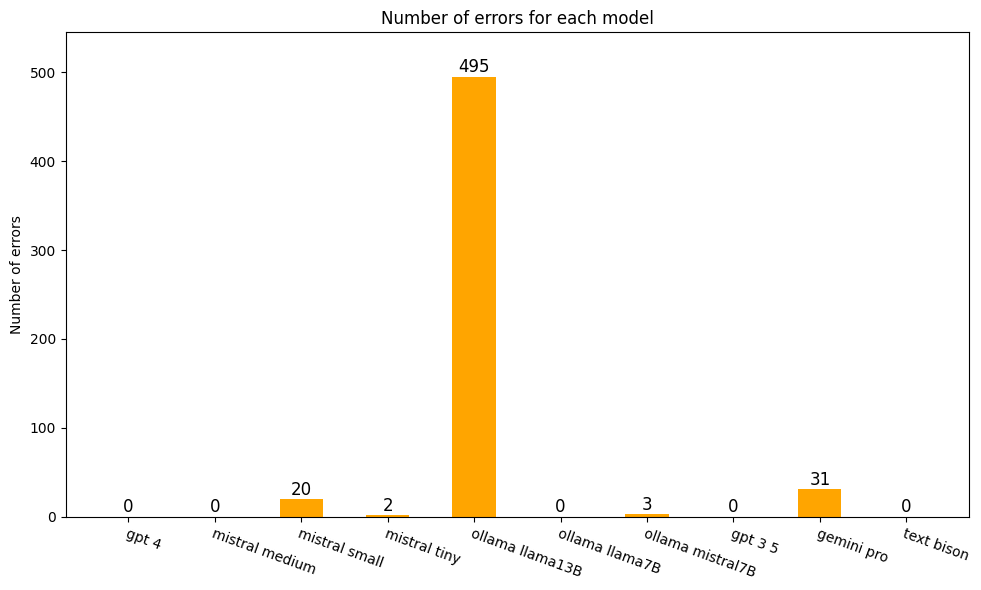

In [20]:
# make a barplot for this data
plt.figure(figsize=(10, 6))  # Adjust the figure size
labels = [col.removesuffix("_ratings").replace("_", " ") for col in ratings_columns]
plt.bar(labels, counts.values(), color='orange', width=0.5)  # Adjust bar width and add colors

# add a data label above the bars
for i, el in enumerate(counts.values()):
    plt.text(i, el + 5, f"{el}", ha='center', fontsize=12)

plt.ylim(0, max(counts.values()) + 50)  # Adjust the y-axis limit for better visualization

plt.xticks(ha='left', fontsize=10, rotation=-20, wrap=True)
plt.ylabel("Number of errors")
plt.title("Number of errors for each model")

# save the plot
plt.savefig("images/errors.png", dpi=300)
plt.tight_layout()
plt.show()